<h1> RBF Solver </h1>
<br>
Using only pure python code and no numpy

In [11]:
%matplotlib inline

<h3> import of matrix code </h3>

In [12]:
def formatMatrix(M):
    return '[' + '\n '.join([' '.join(['{:7.3f}'.format(c) for c in row]) for row in M]) + ' ]'
    

def zeros (rows, cols):
    return [[0]*cols for i in range(rows)];


def identity (rows):
    M = zeros(rows, rows)
    for r in range(rows):
        M[r][r] = 1.0
    return M


def copyMatrix (M):
    return [[v for v in col] for col in M]


def transpose(A):
    rowsA = len(A)
    colsA = len(A[0])
    
    return [[A[i][j] for i in range(rowsA)] for j in range(colsA)]

def scale(A, scale):
    return [[v*scale for v in col] for col in A]

def dot(A, B):
    rowsA = len(A)
    colsA = len(A[0])
    rowsB = len(B)
    colsB = len(B[0])
    
    if colsA != rowsB:
        raise Exception('Number of A columns must equal number of B rows.')
    
    C = zeros(rowsA, colsB)
    
    for i in range(rowsA):
        for j in range(colsB):
            C[i][j] = sum([A[i][k] * B[k][j] for k in range(colsA)])
            
    return C


def inverse(A):
    rowsA = len(A)
    colsA = len(A[0])
    
    if rowsA != colsA:
        raise Exception('Matrix must be square')
    
    AM = copyMatrix(A)
    IM = identity(rowsA)
    
    for fd in range(rowsA):
        fdScaler = 1.0 / AM[fd][fd]
        for j in range(rowsA):
            AM[fd][j] *= fdScaler
            IM[fd][j] *= fdScaler
        for i in list(range(rowsA))[0:fd] + list(range(rowsA))[fd+1:]:
            crScaler = AM[i][fd]
            for j in range(rowsA):
                AM[i][j] = AM[i][j] - crScaler * AM[fd][j]
                IM[i][j] = IM[i][j] - crScaler * IM[fd][j]
    return IM

def solve(A, b):
    Inv = inverse(A)
    return dot(Inv, b)

<h3> Import vector math </h3>

In [13]:
import math

def vAdd(a,b):
    return [ia + ib for ia,ib in zip(a,b)]

def vSub(a,b):
    return [ia + ib for ia,ib in zip(a,b)]

def vScale(a, scale):
    return [ia * scale for ia in a]

def vDot(a,b):
    return sum([ia * ib for ia,ib in zip(a,b)])

def vLength(a):
    return math.sqrt(vDot(a,a))

def vNormalize(a):
    return vScale(a, 1.0/vLength(a))

# RBF Solver
Based on the excellent explications from  http://shihchinw.github.io/2018/10/data-interpolation-with-radial-basis-functions-rbfs.html


kernel functions :


In [14]:
def gaussian(x, sigma=1):
    return math.exp(-x * x / math.pow(sigma, 2.0))

def multiQuadratic(x, sigma=1):
    return math.sqrt(1+ (x*sigma)**2)

def inverseQuadratic(x, sigma=1):
    return 1.0 / (1.0 + (x*sigma)**2)

def inverseMultiQuadratic(x, sigma=1):
    return 1.0 / math.sqrt(1.0 + (x*sigma)**2)

def thinPlate(r):
    return r * r * math.log(max(1e-8, r))

def filmc_curve(x):
    """The fitted ACES tone mapping curve by Krzysztof Narkowicz.
    https://knarkowicz.wordpress.com/2016/01/06/aces-filmic-tone-mapping-curve/
    """
    return (x * (2.51 * x + 0.03)) / (x * (2.43 * x + 0.59) + 0.14)

distance functions :

In [15]:
def normDist(va, vb):
    return vLength(vSub(va,vb))

def dotDist(va, vb):
    d = 1.0 - vDot(vNormalize(va), vNormalize(vb))
    return d

In [16]:
class RBF (object):
    
    def __init__(self, centers, values, distfunc, kernelfunc ):
        """ 
        centers {matrix} : the list of coordinates
        values {matrix} : the list of values for each center
        distfunc {function} : the method used to compute the distance between centers
        kernelfunc {function} : the method used to compute the kernel value
        """
        count = len(centers)
        Phi = zeros(count, count)
        for i in range(count):
            for j in range(i, count):
                dist = distfunc(centers[i], centers[j])
                Phi[i][j] = Phi[j][i] = kernelfunc(dist)
                
        A = Phi
        b = values
                
        self.centers = centers
        self.values = values
        self.dist = distfunc
        self.kernel = kernelfunc
        self.coeffs = solve(A, b)
        
    def evaluate(self, centers):
        """
        centers {matrix} : the list of coordinates we want to evaluate
        """
        Phi = [
            [self.kernel(self.dist(value, center)) for center in self.centers]
            for value in centers
        ]
        return dot(Phi, self.coeffs)




### tests values

#### 1 D tests
Let's test some 1 dimension data to see how several kernel will react


In [17]:
import matplotlib.pyplot as plt

#1D values
def _generate_1D (xvalues, func):
    return [[x] for x in xvalues], [[func(x)] for x in xvalues]

d1_x, d1_y = _generate_1D ([0.05, 0.2, 0.5, 0.6, 0.9, 0.94], lambda x: (x - 0.5) ** 2 + 0.5)

print (d1_x)
print (d1_y)

[[0.05], [0.2], [0.5], [0.6], [0.9], [0.94]]
[[0.7025], [0.59], [0.5], [0.51], [0.66], [0.6936]]


[[0.05], [0.2], [0.5], [0.6], [0.9], [0.94]]
[[0.7025], [0.59], [0.5], [0.51], [0.66], [0.6936]]
[[1513.6290720610123], [-5188.40014030243], [30415.37547267275], [-38376.6090053739], [57684.88445502799], [-46211.39212544635]]


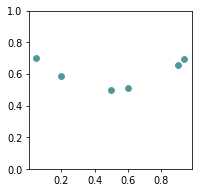

In [18]:
gauss = RBF(d1_x, d1_y, normDist, lambda x:gaussian(x, 1.0))
print (gauss.centers)
print (gauss.values)
print (gauss.coeffs)

plt.figure(figsize=(3, 3), dpi=70)
plt.plot([v[0] for v in d1_x], [v[0] for v in d1_y], 'o', color='#539798')
plt.ylim(0.0, 1.0)
plt.show()


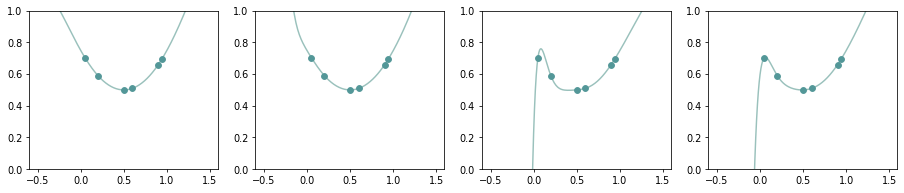

In [19]:

x_sample = [[x*0.01] for x in range(-50,150)]

plt.figure(figsize=(16, 3), dpi=70)

plt.subplot(1, 4, 1)
rbf = RBF(d1_x, d1_y, normDist, lambda x:gaussian(x, 1.5))
y_sample = rbf.evaluate(x_sample)
plt.plot(x_sample, y_sample, color='#9ac1bc')
plt.plot([v[0] for v in d1_x], [v[0] for v in d1_y], 'o', color='#539798')
plt.ylim(0.0, 1.0)

plt.subplot(1, 4, 2)
rbf = RBF(d1_x, d1_y, normDist, lambda x:multiQuadratic(x, 1.5))
y_sample = rbf.evaluate(x_sample)
plt.plot(x_sample, y_sample, color='#9ac1bc')
plt.plot([v[0] for v in d1_x], [v[0] for v in d1_y], 'o', color='#539798')
plt.ylim(0.0, 1.0)

plt.subplot(1, 4, 3)
rbf = RBF(d1_x, d1_y, normDist, lambda x:inverseQuadratic(x, 1.5))
y_sample = rbf.evaluate(x_sample)
plt.plot(x_sample, y_sample, color='#9ac1bc')
plt.plot([v[0] for v in d1_x], [v[0] for v in d1_y], 'o', color='#539798')
plt.ylim(0.0, 1.0)

plt.subplot(1, 4, 4)
rbf = RBF(d1_x, d1_y, normDist, lambda x:inverseMultiQuadratic(x, 1.5))
y_sample = rbf.evaluate(x_sample)
plt.plot(x_sample, y_sample, color='#9ac1bc')
plt.plot([v[0] for v in d1_x], [v[0] for v in d1_y], 'o', color='#539798')
plt.ylim(0.0, 1.0)
plt.show()

#### 2D input 3D output
Let's test some 2d position with colors to see how we can interpolate those.

The color needs to be rounded to 1 decimal to be properly displayed by matplotlib

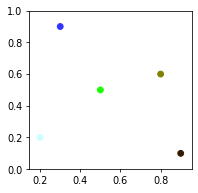

In [20]:
d2_x = [[0.2,0.2], [0.3,0.9], [0.9,0.1], [0.5,0.5], [0.8,0.6]]
d2_y = [[0.8,1,1], [0.2,0.2,1.0], [0.2,.1,0], [0.1,1.0,0], [.5,.5,0.0]]


plt.figure(figsize=(3, 3), dpi=70)
plt.scatter([v[0] for v in d2_x], [v[1] for v in d2_x], color=d2_y)
plt.ylim(0.0, 1.0)
plt.show()

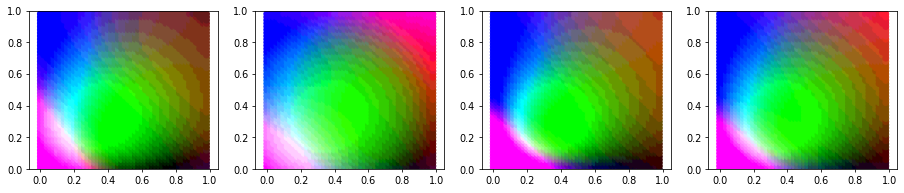

In [21]:
x_sample = [[x*0.02, y*0.02] for x in range(0,50) for y in range(0,50)]

def round_colors(samples):
    return [
        [max(0, min(1, round(v,1))) for v in color]
        for color in samples
    ]    


plt.figure(figsize=(16, 3), dpi=70)

plt.subplot(1, 4, 1)
rbf = RBF(d2_x, d2_y, normDist, lambda x:gaussian(x, 1))
y_sample = round_colors(rbf.evaluate(x_sample))
plt.scatter([v[0] for v in x_sample], [v[1] for v in x_sample], color=y_sample)
plt.ylim(0.0, 1.0)

plt.subplot(1, 4, 2)
rbf = RBF(d2_x, d2_y, normDist, lambda x:multiQuadratic(x, 1.5))
y_sample = round_colors(rbf.evaluate(x_sample))
plt.scatter([v[0] for v in x_sample], [v[1] for v in x_sample], color=y_sample)
plt.ylim(0.0, 1.0)

plt.subplot(1, 4, 3)
rbf = RBF(d2_x, d2_y, normDist, lambda x:inverseQuadratic(x, 1.5))
y_sample = round_colors(rbf.evaluate(x_sample))
plt.scatter([v[0] for v in x_sample], [v[1] for v in x_sample], color=y_sample)
plt.ylim(0.0, 1.0)

plt.subplot(1, 4, 4)
rbf = RBF(d2_x, d2_y, normDist, lambda x:inverseMultiQuadratic(x, 1.5))
y_sample = round_colors(rbf.evaluate(x_sample))
plt.scatter([v[0] for v in x_sample], [v[1] for v in x_sample], color=y_sample)
plt.ylim(0.0, 1.0)

plt.show()